### Import dependencies

In [3]:
# utilities
import re
import numpy as np
import pandas as pd 

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# displaying 
import flask

### load and display the dataset

In [4]:
# importing the dataset 
DATASET_COLUMNS=['target','ids','date','flag','user','text']
DATASET_ENCODING = "ISO-8859-1"
df =pd.read_csv('Sentiment_data.csv',  encoding=DATASET_ENCODING, names=DATASET_COLUMNS)
df.sample(5)

,target,ids,date,flag,user,text
1071486,4,1966338210,Fri May 29 17:35:01 PDT 2009,NO_QUERY,himynameisanalu,@TheMasonMusso When U guys will come to Brazil...
1041642,4,1957101369,Thu May 28 23:31:16 PDT 2009,NO_QUERY,fani06,@Leoyu0215 Leo processing.. Give me a little b...
603324,0,2221632271,Thu Jun 18 05:44:25 PDT 2009,NO_QUERY,maconcon,@Mikaela911 yeah...i'm obviously not yet ready
15079,0,1553982579,Sat Apr 18 15:44:46 PDT 2009,NO_QUERY,h2_200161813,I just droped my phone and dented it
323712,0,2005544004,Tue Jun 02 09:50:52 PDT 2009,NO_QUERY,SalinaNissa,My tummmy is acting funnny ahhhhh


In [5]:
df.head

<bound method NDFrame.head of          target         ids                          date      flag  \
0             0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1             0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2             0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3             0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4             0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
...         ...         ...                           ...       ...   
1599995       4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996       4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997       4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998       4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599999       4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                    user                                               text  
0        _TheSpecialOne_  @switchfoot h

In [6]:
df.columns

Index(['target', 'ids', 'date', 'flag', 'user', 'text'], dtype='object')

In [7]:
print('length of data is',len(df) )

length of data is 1600000


In [8]:
df.shape

(1600000, 6)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   target  1600000 non-null  int64 
 1   ids     1600000 non-null  int64 
 2   date    1600000 non-null  object
 3   flag    1600000 non-null  object
 4   user    1600000 non-null  object
 5   text    1600000 non-null  object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [11]:
df.dtypes

target     int64
ids        int64
date      object
flag      object
user      object
text      object
dtype: object

In [14]:
np.sum(df.isnull().any(axis=1))

np.int64(0)

In [15]:
print('Count of columns in the data is: ',len(df.columns))
print('Count of rows in the data is: ',len(df))

Count of columns in the data is:  6
Count of rows in the data is:  1600000


In [16]:
df['target'].unique()

array([0, 4])

In [17]:
df['target'].nunique()

2

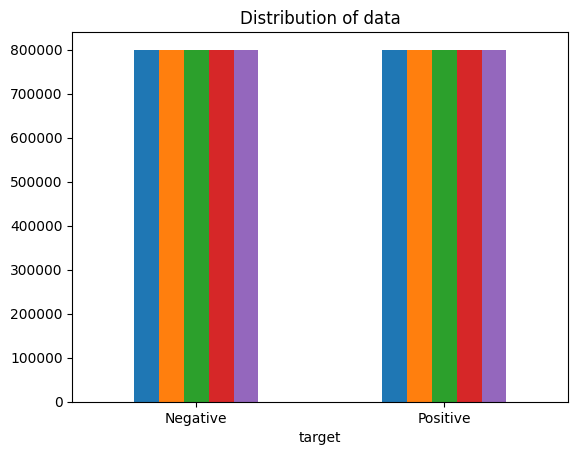

In [18]:
# Plotting the distribution for dataset.
ax = df.groupby('target').count().plot(kind='bar', title='Distribution of data', legend=False)
ax.set_xticklabels(['Negative','Positive',], rotation=0)

# Sorting data in lists.
text,sentiment = list(df['text']), list(df['target'])

<Axes: xlabel='target', ylabel='count'>

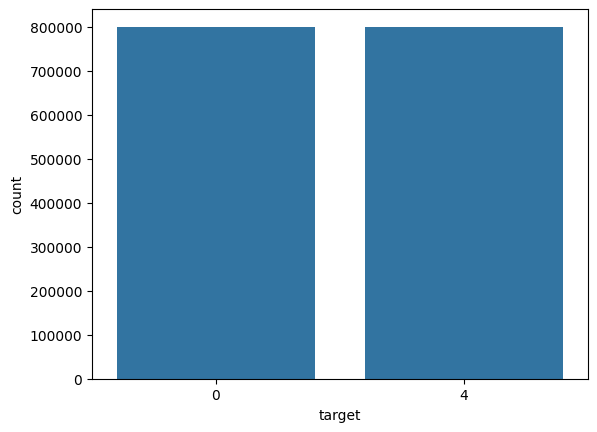

In [19]:
sns.countplot(x='target', data=df)

In [20]:
data=df[['text','target']]

In [22]:
data['target'] = data['target'].replace(4,1)

C:\Users\DUBAI\AppData\Local\Temp\ipykernel_22332\2499609609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(4,1)


In [23]:
data['target'].unique()

array([0, 1])

In [27]:
data_pos = data[data['target'] == 1]
data_neg = data[data['target'] == 0]

In [28]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_pos.iloc[:int(20000)]

In [29]:
dataset = pd.concat([data_pos, data_neg])

In [30]:
dataset['text']=dataset['text'].str.lower()
dataset['text'].tail()

819995    we just met some awesome people at t.g.i fridays 
819996    oh my goodness . my feet are the most sensitiv...
819997                                    @hey_angy hahaha 
819998    @lamartian30 pfft school is koo. i'm ranked 2n...
819999    stuffed. working out, shower,movie night, thn ...
Name: text, dtype: object

In [31]:
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from',
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're','s', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those',
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [32]:
STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
dataset['text'] = dataset['text'].apply(lambda text: cleaning_stopwords(text))
dataset['text'].head()

800000                love @health4uandpets u guys r best!!
800001    im meeting one besties tonight! cant wait!! - ...
800002    @darealsunisakim thanks twitter add, sunisa! g...
800003    sick really cheap hurts much eat real food plu...
800004                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [33]:
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
dataset['text']= dataset['text'].apply(lambda x: cleaning_punctuations(x))
dataset['text'].tail()

819995                       met awesome people tgi fridays
819996    oh goodness  feet sensitive part body  shit fe...
819997                                       heyangy hahaha
819998    lamartian30 pfft school koo im ranked 2nd expe...
819999    stuffed working out showermovie night thn slee...
Name: text, dtype: object

In [34]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_repeating_char(x))
dataset['text'].tail()

819995                       met awesome people tgi fridays
819996    oh goodness  feet sensitive part body  shit fe...
819997                                       heyangy hahaha
819998    lamartian30 pfft school koo im ranked 2nd expe...
819999    stuffed working out showermovie night thn slee...
Name: text, dtype: object

In [35]:
def cleaning_URLs(data):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ',data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_URLs(x))
dataset['text'].tail()

819995                       met awesome people tgi fridays
819996    oh goodness  feet sensitive part body  shit fe...
819997                                       heyangy hahaha
819998    lamartian30 pfft school koo im ranked 2nd expe...
819999    stuffed working out showermovie night thn slee...
Name: text, dtype: object

In [36]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)
dataset['text'] = dataset['text'].apply(lambda x: cleaning_numbers(x))
dataset['text'].tail()

819995                       met awesome people tgi fridays
819996    oh goodness  feet sensitive part body  shit fe...
819997                                       heyangy hahaha
819998    lamartian pfft school koo im ranked nd experim...
819999    stuffed working out showermovie night thn slee...
Name: text, dtype: object

In [37]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'w+')
dataset['text'] = dataset['text'].apply(tokenizer.tokenize)
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [38]:
import nltk
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data
dataset['text']= dataset['text'].apply(lambda x: stemming_on_text(x))
dataset['text'].head()

800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [42]:
import nltk
nltk.download('wordnet')
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data
dataset['text'] = dataset['text'].apply(lambda x: lemmatizer_on_text(x))
dataset['text'].head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\DUBAI\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


800000           []
800001          [w]
800002    [w, w, w]
800003           []
800004           []
Name: text, dtype: object

In [43]:
X=data.text
y=data.target

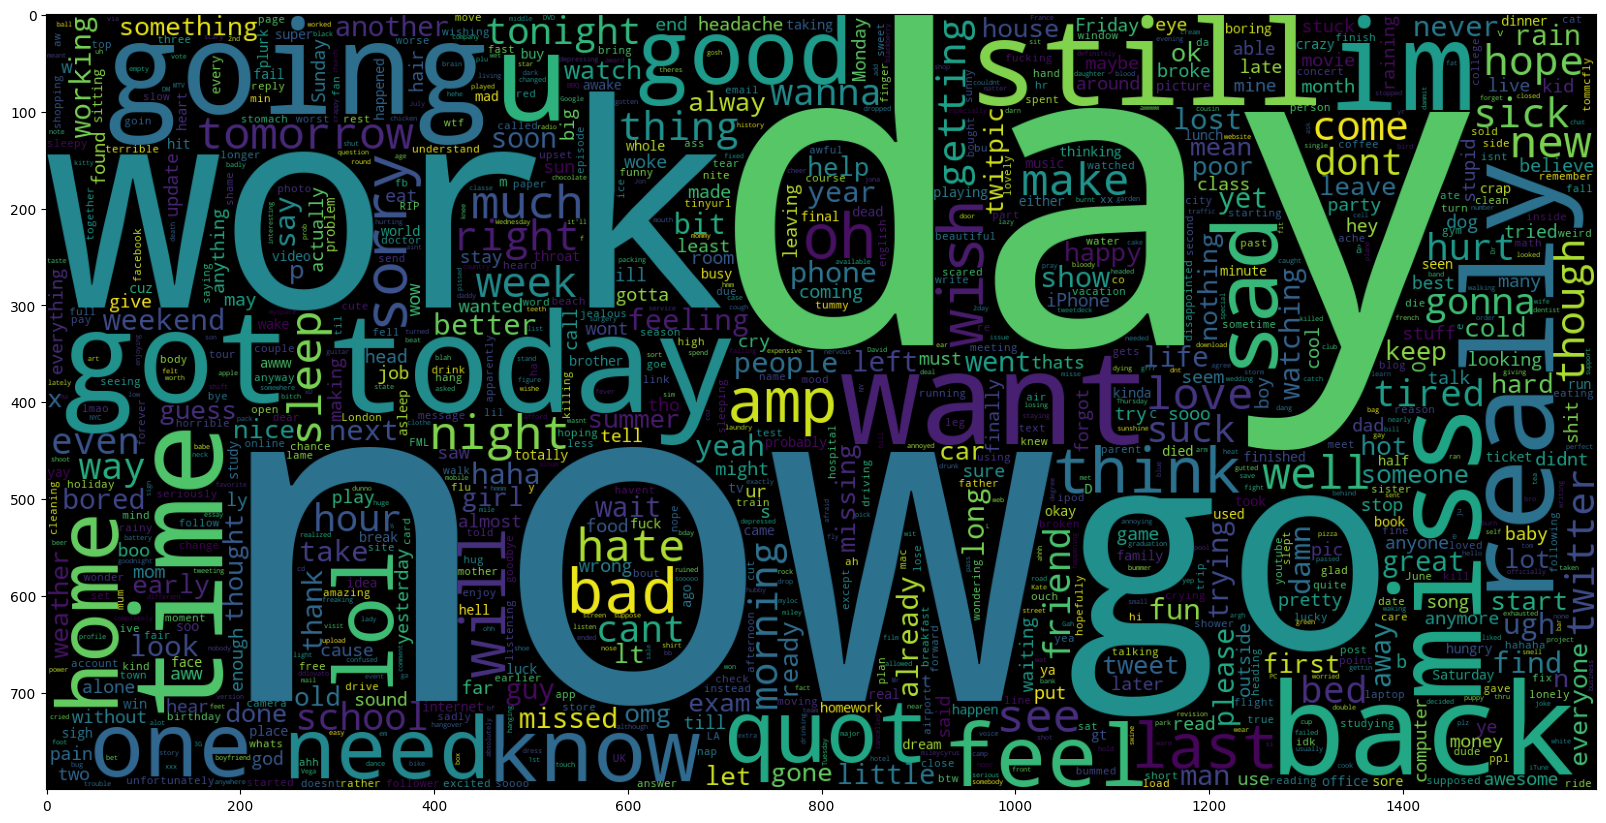

In [44]:
data_neg = data['text'][:800000]
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

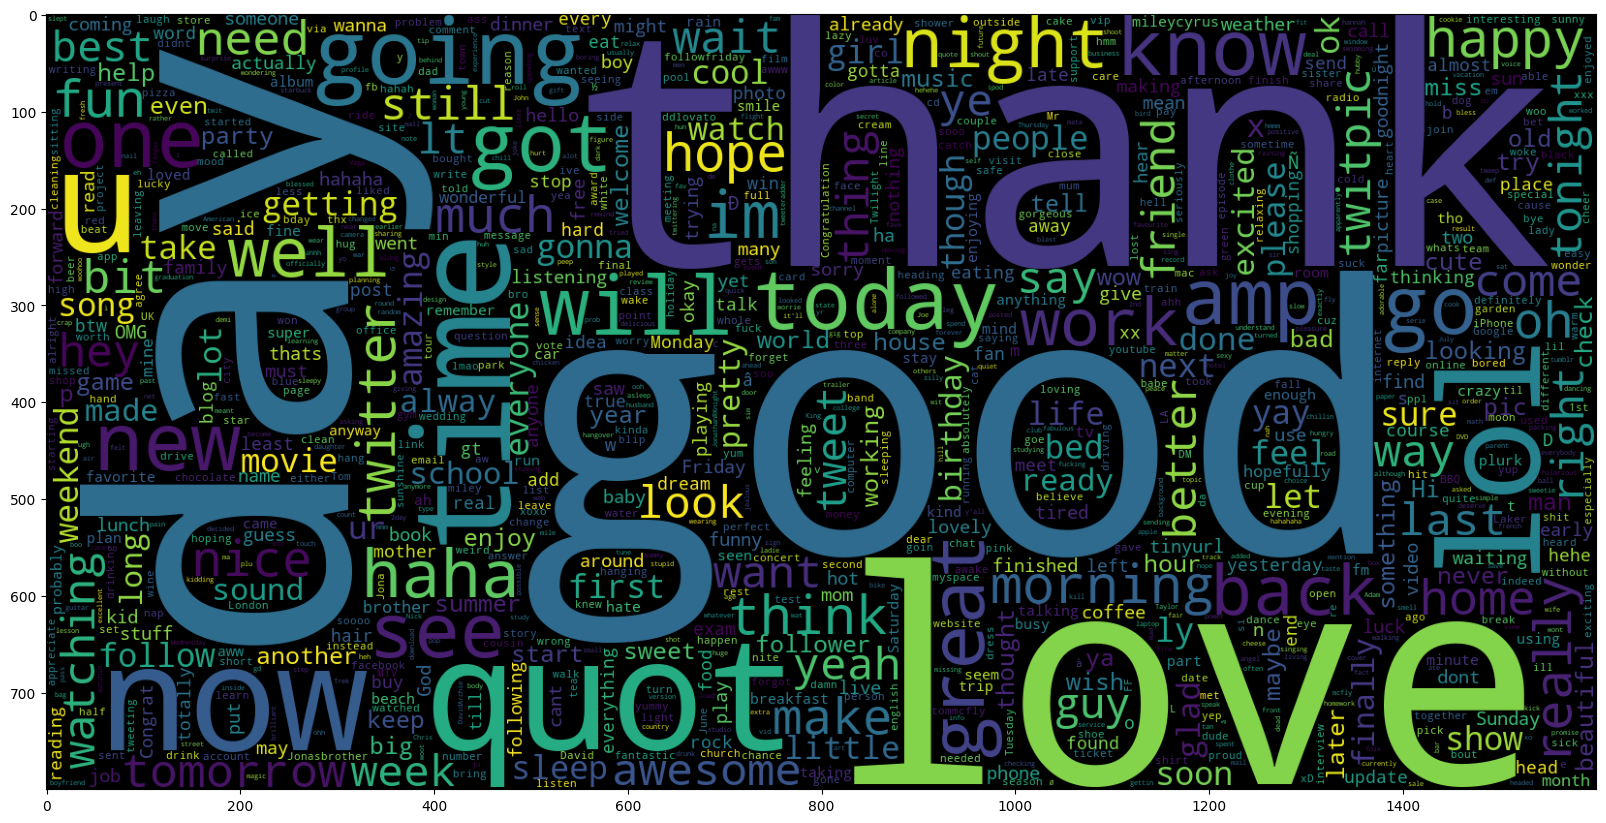

In [45]:
data_pos = data['text'][800000:]
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (20,20))
plt.imshow(wc)

In [46]:
# Separating the 95% data for training data and 5% for testing data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.05, random_state =26105111)

In [48]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  500000


In [49]:
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)

In [50]:
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative', 'Positive']
    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cf_matrix, annot=labels, cmap='Blues', fmt='',
                xticklabels=categories, yticklabels=categories)
    plt.xlabel("Predicted values", fontdict={'size': 14}, labelpad=10)
    plt.ylabel("Actual values", fontdict={'size': 14}, labelpad=10)
    plt.title("Confusion Matrix", fontdict={'size': 18}, pad=20)
    plt.show()

              precision    recall  f1-score   support

           0       0.81      0.79      0.80     40100
           1       0.80      0.81      0.80     39900

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



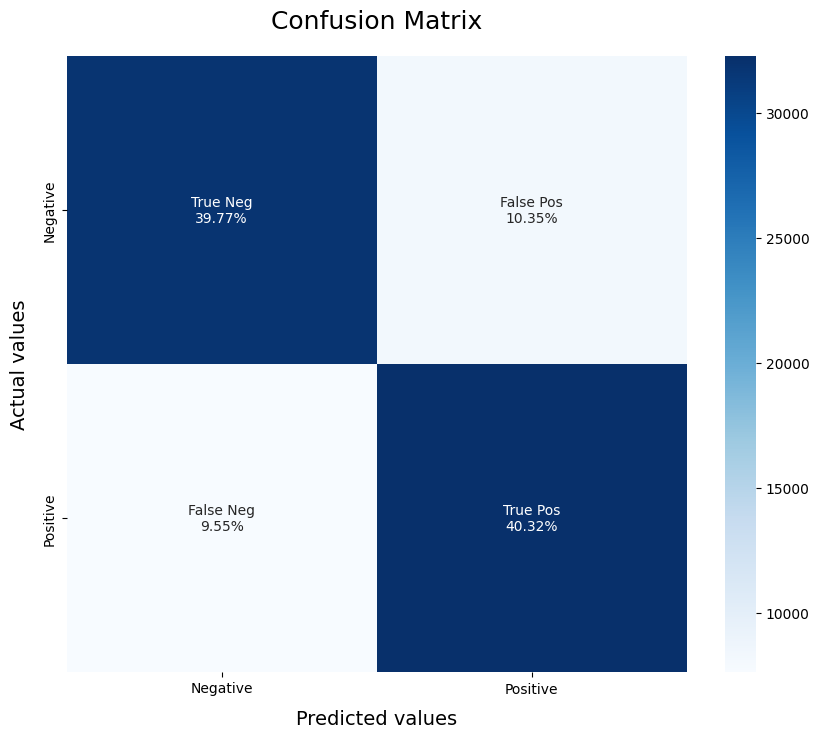

In [51]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

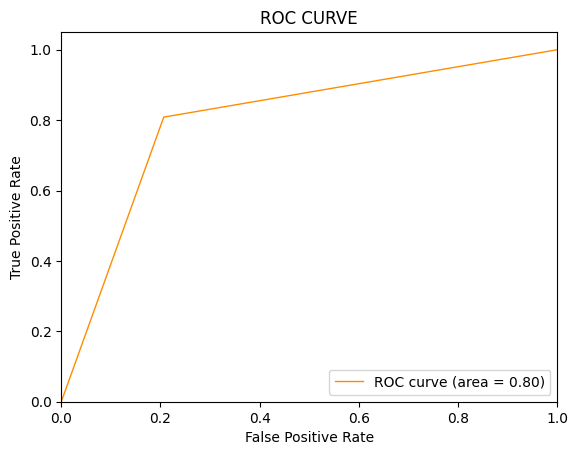

In [52]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.82      0.81      0.81     40100
           1       0.81      0.82      0.82     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



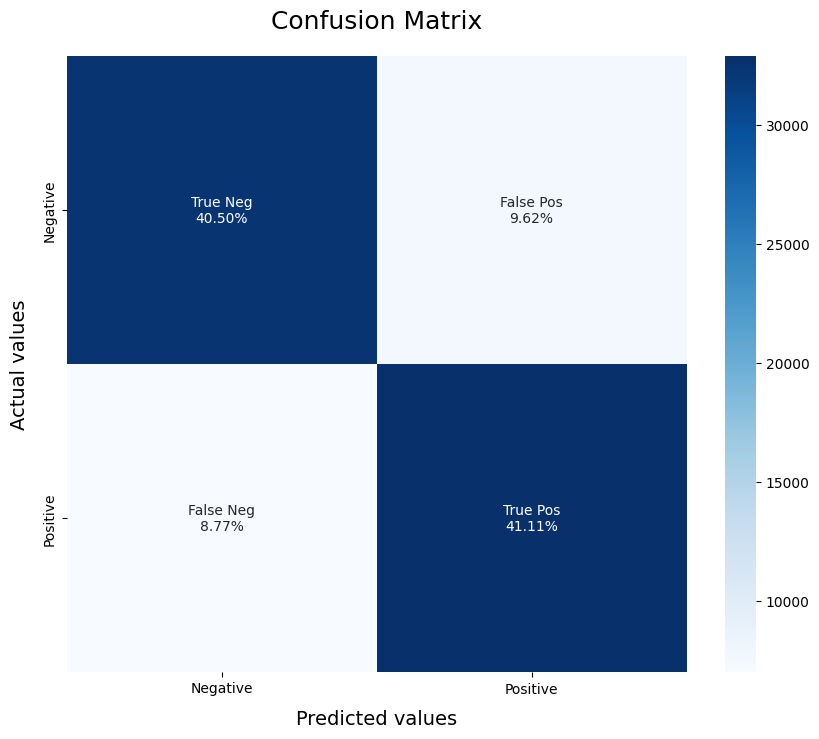

In [53]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

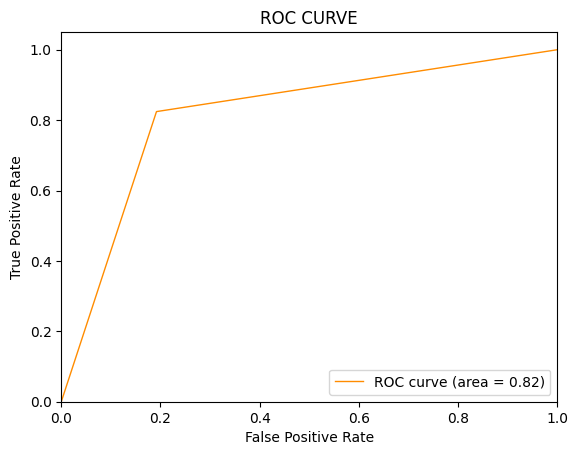

In [54]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

              precision    recall  f1-score   support

           0       0.83      0.81      0.82     40100
           1       0.82      0.84      0.83     39900

    accuracy                           0.82     80000
   macro avg       0.82      0.82      0.82     80000
weighted avg       0.82      0.82      0.82     80000



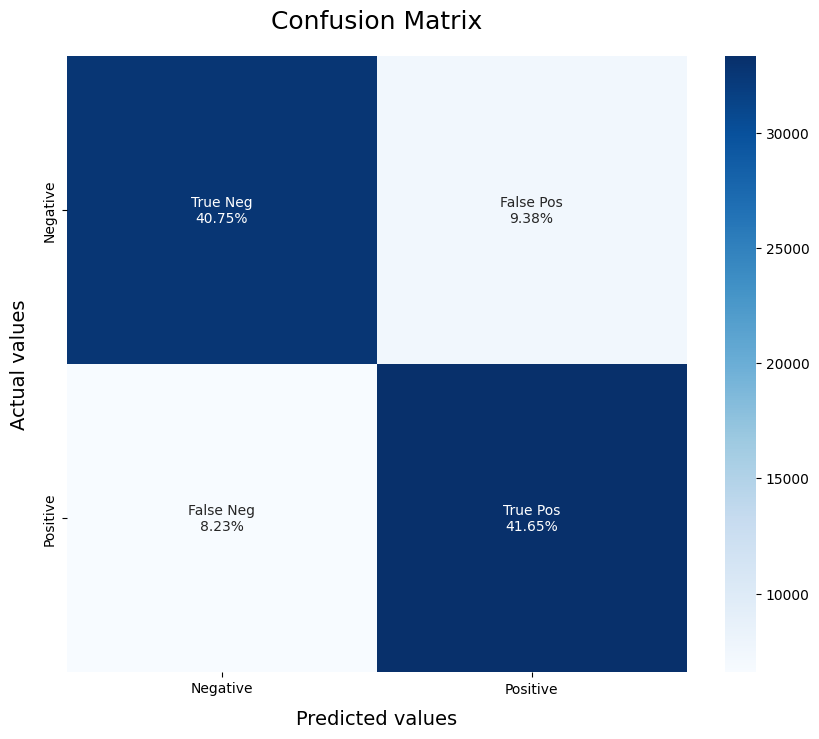

In [55]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

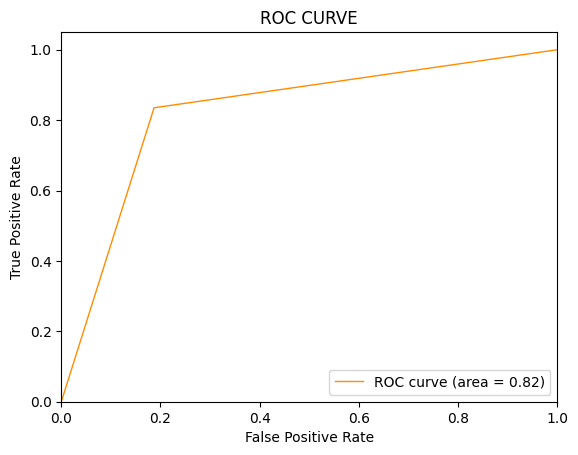

In [56]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [57]:
import joblib
joblib.dump(LRmodel, 'LRmodel.pkl')
joblib.dump(vectoriser, 'vectorizer.pkl')

['vectorizer.pkl']